In [2]:
!gunzip ecoli_mda_lane1_left.downsampled.fastq.gz
!gunzip ecoli_mda_lane1_right.downsampled.fastq.gz
!gunzip 100x.1.fastq.gz
!gunzip 100x.2.fastq.gz

## Часть 1: анализ ридов Illumina

### 0. BWA MEM

In [3]:
!bwa index MG1655-K12.fasta > /dev/null 2>&1
!bwa mem MG1655-K12.fasta ecoli_mda_lane1_right.downsampled.fastq ecoli_mda_lane1_left.downsampled.fastq 1> alignment1.sam 2> /dev/null

In [4]:
!samtools flagstat alignment1.sam

5869326 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
40560 + 0 supplementary
0 + 0 duplicates
5706946 + 0 mapped (97.23% : N/A)
5828766 + 0 paired in sequencing
2914383 + 0 read1
2914383 + 0 read2
5151488 + 0 properly paired (88.38% : N/A)
5647486 + 0 with itself and mate mapped
18900 + 0 singletons (0.32% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [5]:
!bwa mem MG1655-K12.fasta 100x.1.fastq 100x.2.fastq 1> alignment2.sam 2> /dev/null

In [7]:
!samtools flagstat alignment2.sam

5000581 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
581 + 0 supplementary
0 + 0 duplicates
4991553 + 0 mapped (99.82% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4978334 + 0 properly paired (99.57% : N/A)
4983734 + 0 with itself and mate mapped
7238 + 0 singletons (0.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### 1. Покрытие генома.

In [1]:
import pysam as ps
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import time
from progress.bar import IncrementalBar
from tqdm import tqdm

In [9]:
def coverage(sam, fasta):
    align = ps.AlignmentFile(sam, 'rb')
    reference = SeqIO.read(fasta, 'fasta').seq
    cov = {}
    
    for read in tqdm(align.fetch()):
        start, end = read.reference_start, read.reference_end
        if start and end:
            for i in range(start, end):
                if i in cov:
                    cov[i] += 1
                else:
                    cov[i] = 1
            
    return cov

In [17]:
cov_dataset1 = coverage('alignment1.sam', 'MG1655-K12.fasta')

5869326it [07:46, 12574.40it/s]


In [20]:
cov_dataset2 = coverage('alignment2.sam', 'MG1655-K12.fasta')

5000581it [07:07, 11700.51it/s]


In [11]:
reference = SeqIO.read('MG1655-K12.fasta', 'fasta').seq

In [ ]:
cov_dataset2 = cov_dataset1

In [123]:
def graphics(cov):
    positions,c =  list(cov.keys()), list(cov.values())
    
    fig = plt.figure(figsize=(15, 15))
    
    plt.xlabel('Позиция', fontsize=20, color='green')
    plt.ylabel('Количество ридов', fontsize=20, color='green')
    plt.rcParams.update({'font.size': 20})
    
    plt.plot(positions, c, color='green', linewidth = 0, marker = 'o', 
             markersize = 5, markerfacecolor = 'lawngreen',
             markeredgecolor = 'limegreen', markeredgewidth = 0.5)
    plt.grid()

Для первого набора данных имеем следующую статистику:

Среднее покрытие  123.6573531880768
Процент покрытого генома  95.5811577851864


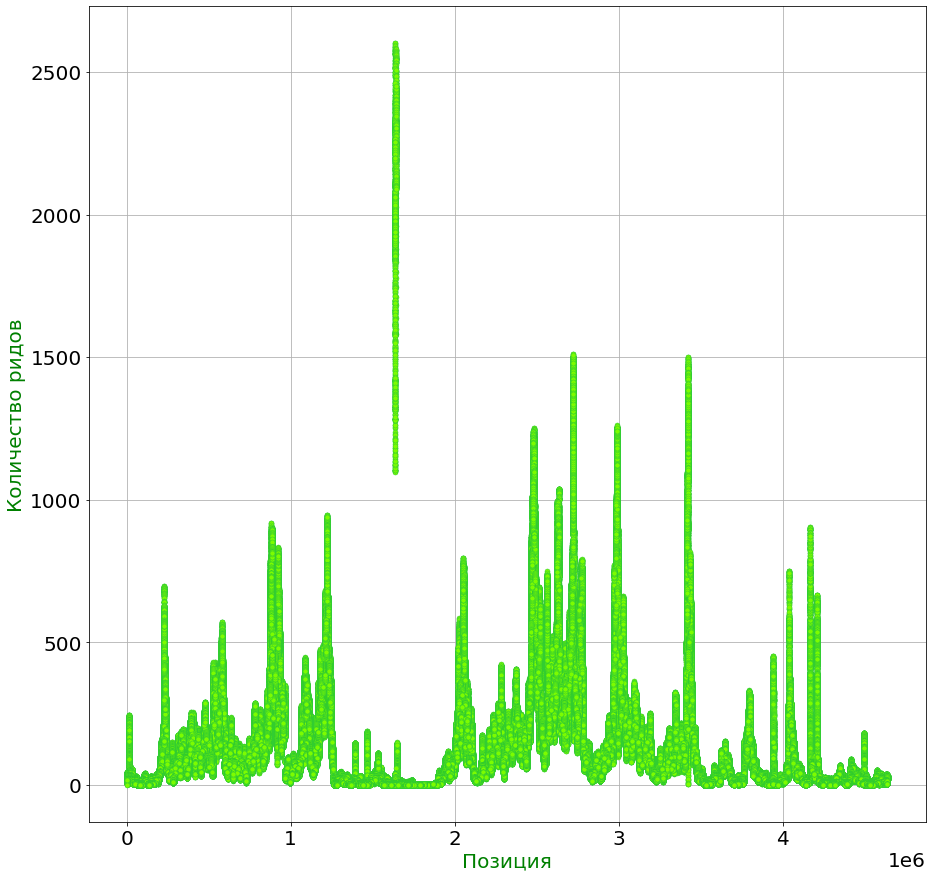

In [124]:
print('Среднее покрытие ', np.array(list(cov_dataset1.values())).mean())
print('Процент покрытого генома ', round(len(cov_dataset1.keys()) / len(reference), 15) * 100)
graphics(cov_dataset1)

Для втрого набора данных имеем следующую статистику:

Среднее покрытие  105.23084082075682
Процент покрытого генома  99.0083943341819


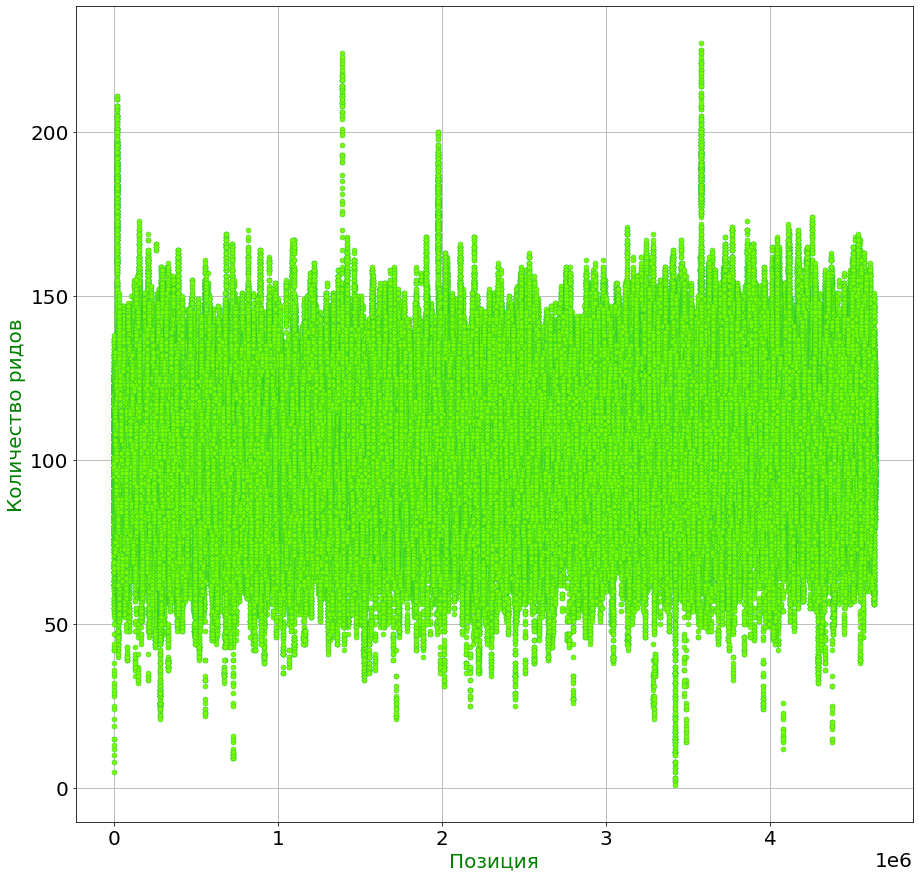

In [125]:
print('Среднее покрытие ', np.array(list(cov_dataset2.values())).mean())
print('Процент покрытого генома ', round(len(cov_dataset2.keys()) / len(reference), 15) * 100)
graphics(cov_dataset2)

### 2. Распределение расстояния вставки.

In [58]:
from collections import Counter
from collections import OrderedDict


def templl(sam, alpha):
    align = ps.AlignmentFile(sam, "r") 
    templ = []
    
    for read in tqdm(align.fetch()):
        if read.template_length > 0:
            #templ.append(read.template_length)
            #templ.append(read.next_reference_start - read.reference_end)
            templ.append(read.tlen)
    
    count = Counter(templ)
    x = np.array(list(range(len(count))))
    
    y = np.array([count[i] for i in range(len(count))])
    x, y = x[170:270], y[170:270]
    
    
    
    mean = 0
    sorted_count = OrderedDict(sorted(count.items(), key=lambda x: -x[1]))
    p, s = list(sorted_count.keys()), list(sorted_count.values())
    pair = np.array([p[170:270], s[170:270]])
    for i in range(len(x)):
        mean += x[i] * y[i]
    mean /= np.sum(y)
    
    cnt, l, r = 0, 0, 0
    left, right = sum(y) * (1 - alpha) / 2, sum(y) * (1 + alpha) / 2
    for index, elem in enumerate(y):
        cnt += elem
        if cnt > left and l == 0:
            l = index
        if cnt > right and r == 0:
            r = index
            break
            
    print('Средняя длина вставки', mean)
    print('Среднеквадратичное отклонение вставки', 
          np.sqrt(np.sum((x - mean) ** 2) / (np.sum(pair[0]) - 1)))
    print('Доверительный 95%-интервал для ридов', '(', x[l], ',', x[r], ')')
            
    plt.figure(figsize=(15, 15))
    plt.xlabel('Расстояние вставки')
    plt.ylabel('Количество ридов в заданным расстоянием вставки')    
    plt.axvline(x[l], linestyle='-.', color='black')
    plt.axvline(x[r], linestyle='-.', color='black')
    plt.plot(x, y, color='green', linewidth = 0, marker = 'o', 
             markersize = 5, markerfacecolor = 'green',
             markeredgecolor = 'lawngreen', markeredgewidth = 0.5)
    plt.grid()
    return x, y

5869326it [00:32, 181230.24it/s]


Средняя длина вставки 220.15260837625846
Среднеквадратичное отклонение вставки 1.7724577497874658
Доверительный 95%-интервал для ридов ( 91 , 329 )


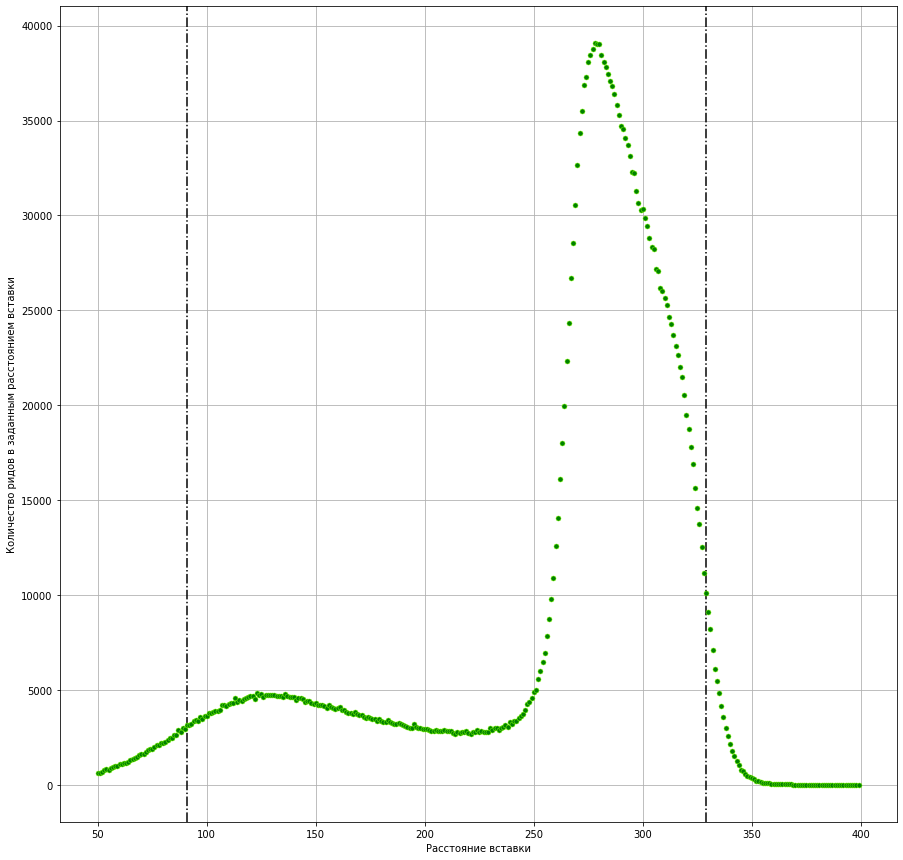

In [50]:
temp1 = templl('alignment1.sam', 0.95)

5000581it [00:17, 289499.43it/s]


Средняя длина вставки 215.38869903812966
Среднеквадратичное отклонение вставки 0.02652474944368198
Доверительный 95%-интервал для ридов ( 196 , 235 )


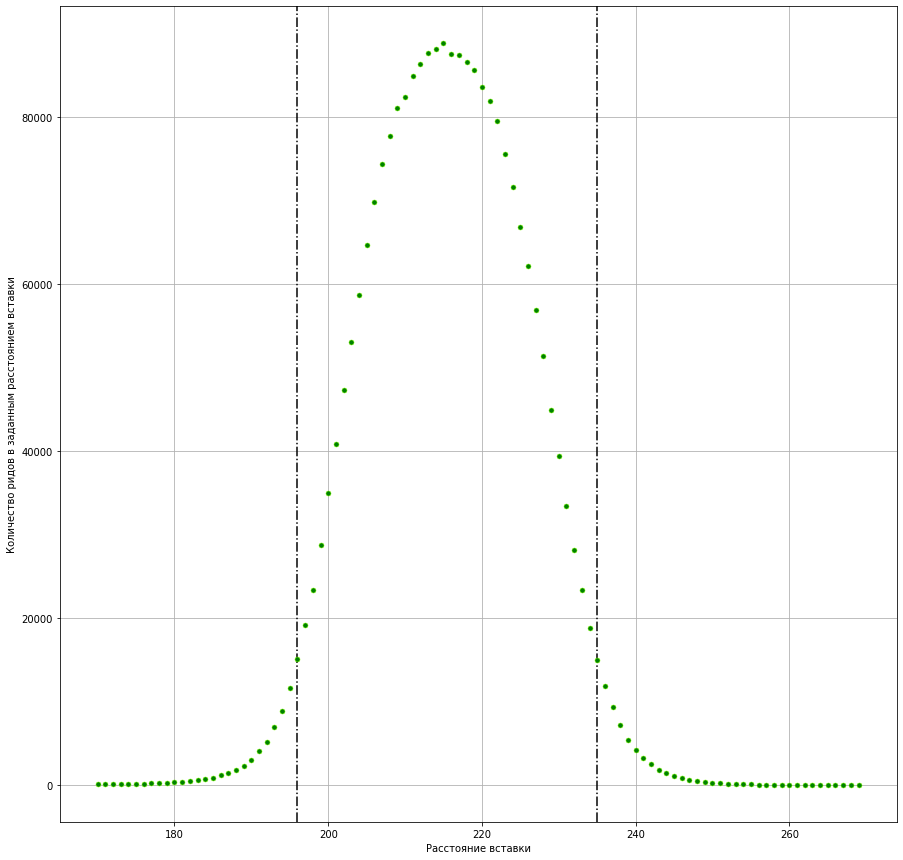

In [59]:
temp2 = templl('alignment2.sam', 0.95)

### 3. Частоты различных замен

In [86]:
import pandas as pd

In [82]:
!samtools view -S -b alignment1.sam > alignment1.bam
!samtools sort alignment1.bam > aligment1_sorted.bam
!samtools index aligment1_sorted.bam

In [381]:
def matrix(sam, ref):
    align = ps.AlignmentFile(sam, threads=4)
    reference = SeqIO.read(ref, 'fasta')
    
    m = {nucl1 : {nucl2 : 0 for nucl2 in ['A', 'G', 'C', 'T', '']} 
          for nucl1 in ['A', 'G', 'C', 'T']}
    
    for col in tqdm(align.pileup()):
        refnucl = reference[col.reference_pos]
        for nucl in ['A', 'C', 'T', 'G', '']:
            m[refnucl][nucl] += Counter(col.get_query_sequences())[nucl]
    return m

def matrix2(m):
    m2 = m
    for col in m2:
        m2[col][col] = '_'
    return m2  

In [384]:
mat1 = matrix('aligment1_sorted.bam', 'MG1655-K12.fasta')

4461122it [13:03, 5696.11it/s] 


Матрица частот замен для первого набора данных:

In [386]:
m1 = matrix2(mat1)
df = pd.DataFrame(mat1)
df.drop([''],axis = 0)

,A,G,C,T
A,_,54128,114811,80061
G,78890,_,62497,145433
C,368949,130470,_,251825
T,67112,130321,98316,_


In [88]:
!samtools view -S -b alignment2.sam > alignment2.bam
!samtools sort alignment2.bam > aligment2_sorted.bam
!samtools index aligment2_sorted.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


In [195]:
mat2 = matrix('aligment2_sorted.bam', 'MG1655-K12.fasta')

4639670it [12:29, 6191.00it/s]


Матрица частот замен для второго набора данных:

In [215]:
m2 = dict(mat2)
df = pd.DataFrame(m2)
df.drop([''],axis = 0)

,A,G,C,T
A,_,6728,20761,2460
G,22743,_,12826,22809
C,119290,17618,_,35701
T,14090,22526,23739,_


In [193]:
def mean_errors(matrix):
    df = pd.DataFrame(matrix)
    df['sum'] = df.sum(axis=1)
    df = df.div(df["sum"], axis=0)
    df = df.drop('sum', axis=1)
    return (100 * (4 - df['A']['A'] - df['C']['C'] - df['G']['G'] - df['T']['T']))

Cредний процент ошибок в ридах для первого набора данных:

In [194]:
mean_errors(mat1)

2.5780101094695973

Средний процент ошибок в ридах для второго набора данных:

In [197]:
mean_errors(mat2)

0.5659726051699954

## Часть 2: анализ ридов IonTorrent

### 1. Статистика ридов IonTorrent

In [61]:
!gunzip B22-730.fastq.gz
!gunzip C24-698.fastq.gz

In [63]:
!bwa index DH10B-K12.fasta > /dev/null 2>&1

In [15]:
!bwa mem DH10B-K12.fasta B22-730.fastq 1> alignment3.sam 2> /dev/null
!bwa mem DH10B-K12.fasta C24-698.fastq 1> alignment4.sam 2> /dev/null

In [126]:
!samtools flagstat alignment3.sam

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


#### Покрытие генома (график, процент покрытого генома, среднее покрытие)

In [127]:
reference = SeqIO.read('DH10B-K12.fasta', 'fasta').seq

686667it [02:04, 5511.21it/s]


Среднее покрытие  35.7038444975658
Процент покрытого генома  99.9997652650787


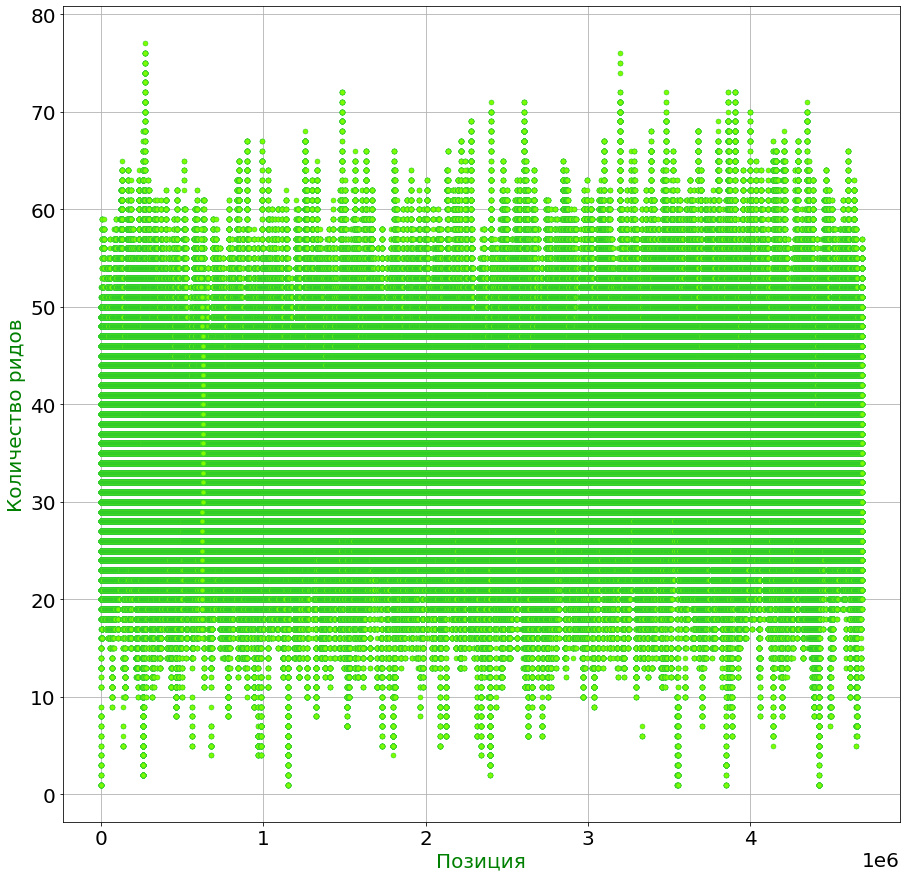

In [128]:
cov_dataset3 = coverage('alignment3.sam', 'DH10B-K12.fasta')
print('Среднее покрытие ', np.array(list(cov_dataset3.values())).mean())
print('Процент покрытого генома ', round(len(cov_dataset3.keys()) / len(reference), 15) * 100)
graphics(cov_dataset3)

497384it [01:43, 4815.26it/s]


Среднее покрытие  34.03713890214471
Процент покрытого генома  99.9879431608594


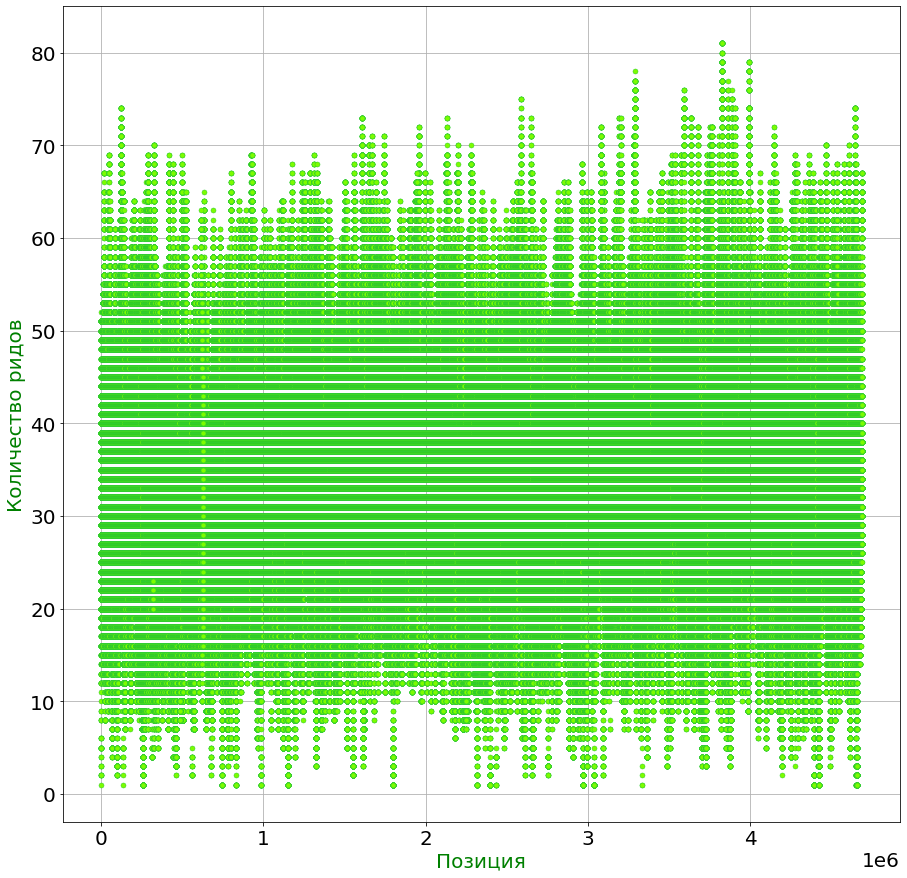

In [129]:
cov_dataset4 = coverage('alignment4.sam', 'DH10B-K12.fasta')
print('Среднее покрытие ', np.array(list(cov_dataset4.values())).mean())
print('Процент покрытого генома ', round(len(cov_dataset4.keys()) / len(reference), 15) * 100)
graphics(cov_dataset4)

#### Таблица частот замен/вставок/удалений

In [226]:
!samtools view -S -b alignment3.sam > alignment3.bam
!samtools sort alignment3.bam > aligment3_sorted.bam
!samtools index aligment3_sorted.bam

In [227]:
mat3 = matrix('aligment3_sorted.bam', 'DH10B-K12.fasta')

4685574it [05:18, 14733.24it/s]


In [232]:
pd.DataFrame(matrix2(mat3))

,A,G,C,T
A,_,13536,6759,7522
G,20116,_,5243,6101
C,6161,4676,_,20682
T,7397,6942,13032,_
,88856,57428,57546,89543


#### Средний процент ошибок в ридах

In [230]:
mean_errors(mat3)

0.3047476985897579

#### Статистика длин инделов

In [471]:
def indel(sam):
    align = ps.AlignmentFile(sam, "r") 

    lenght = []
    
    for x in align.fetch():
        if x.cigartuples:
            for i, l in x.cigartuples:
                if i == 1 or i == 2:
                    lenght.append(l)

    counter = Counter(lenght)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x = list(counter.keys())
    y = list(counter.values())
    count_y = Counter(y)
    p = []
    for Y in y:
        p.append(Y / sum(y))
    p = np.array(p)
    plt.plot(x, p * 100, color='green', linewidth = 1, marker = 'o', 
             markersize = 5, markerfacecolor = 'lawngreen',
             markeredgecolor = 'limegreen', markeredgewidth = 0.5)

    plt.xlabel('Длина индела')
    plt.ylabel('Процент инделов с такой длиной')
    print('Общее количество инделов', sum(y))
    plt.grid()

Общее количество инделов 843256


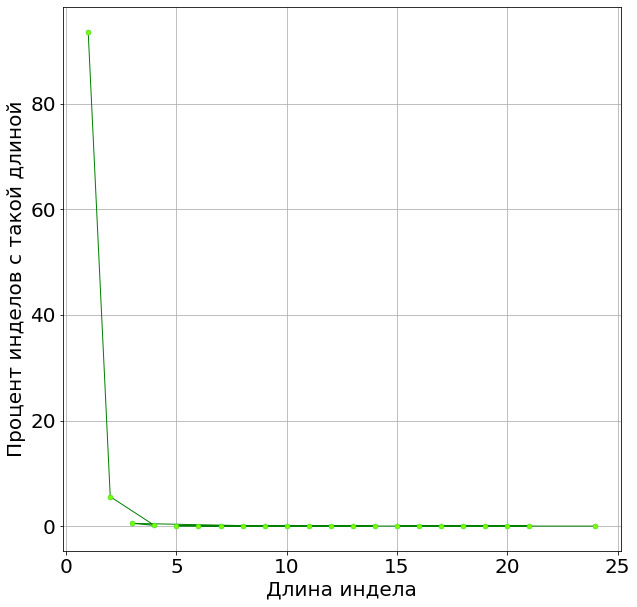

In [473]:
indel('alignment3.sam')

Общее количество инделов 843256


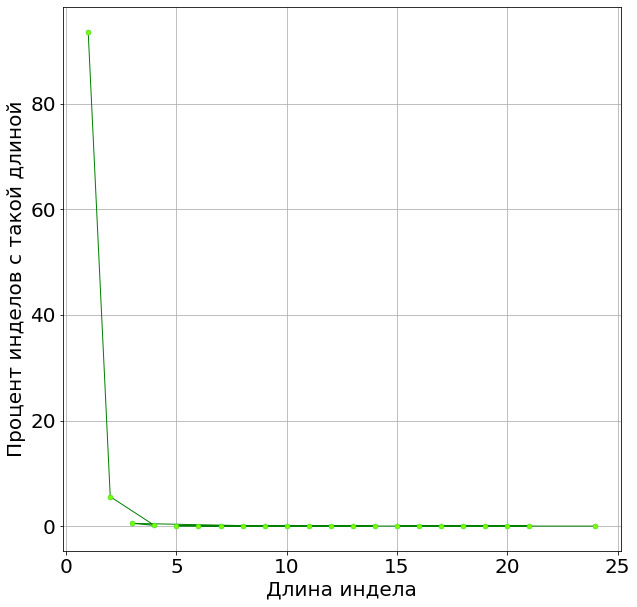

In [474]:
indel('alignment4.sam')

#### Процент инделов, находящихся рядом с гомополимерными участками (много одинаковых нуклеотидов подряд)

In [44]:
homopolymers_ref = {(nucl, k) : 0 for nucl in 
                    ['A', 'G', 'C', 'T'] for k in range(5, 23)}
homopolymers_reads = {(nucl, k) : 0 for nucl in 
                      ['A', 'G', 'C', 'T'] for k in range(5, 100)}

def proc_indel(flag = True, sam = 'alignment3.sam', fasta = 'DH10B-K12.fasta'):
    nucl, lenght = '', 0
    if flag:
        for read in tqdm(ps.AlignmentFile(sam, "rb").fetch()):
            for nucl in read.seq:
                if lenght == 0:
                    last = nucl
                if nucl == last:
                    lenght += 1
                elif lenght > 5:
                    homopolymers_reads[(last, lenght)] += 1
                    lenght = 0
    else:
        ref = SeqIO.read(fasta, 'fasta').seq
        for nucl in ref:
            if lenght == 0:
                last = nucl
            if nucl == last:
                lenght += 1
            elif lenght > 5:
                homopolymers_ref[(last, lenght)] += 1
                lenght = 0

In [45]:
proc_indel()

497384it [02:00, 4126.50it/s]


In [46]:
proc_indel(flag = False)

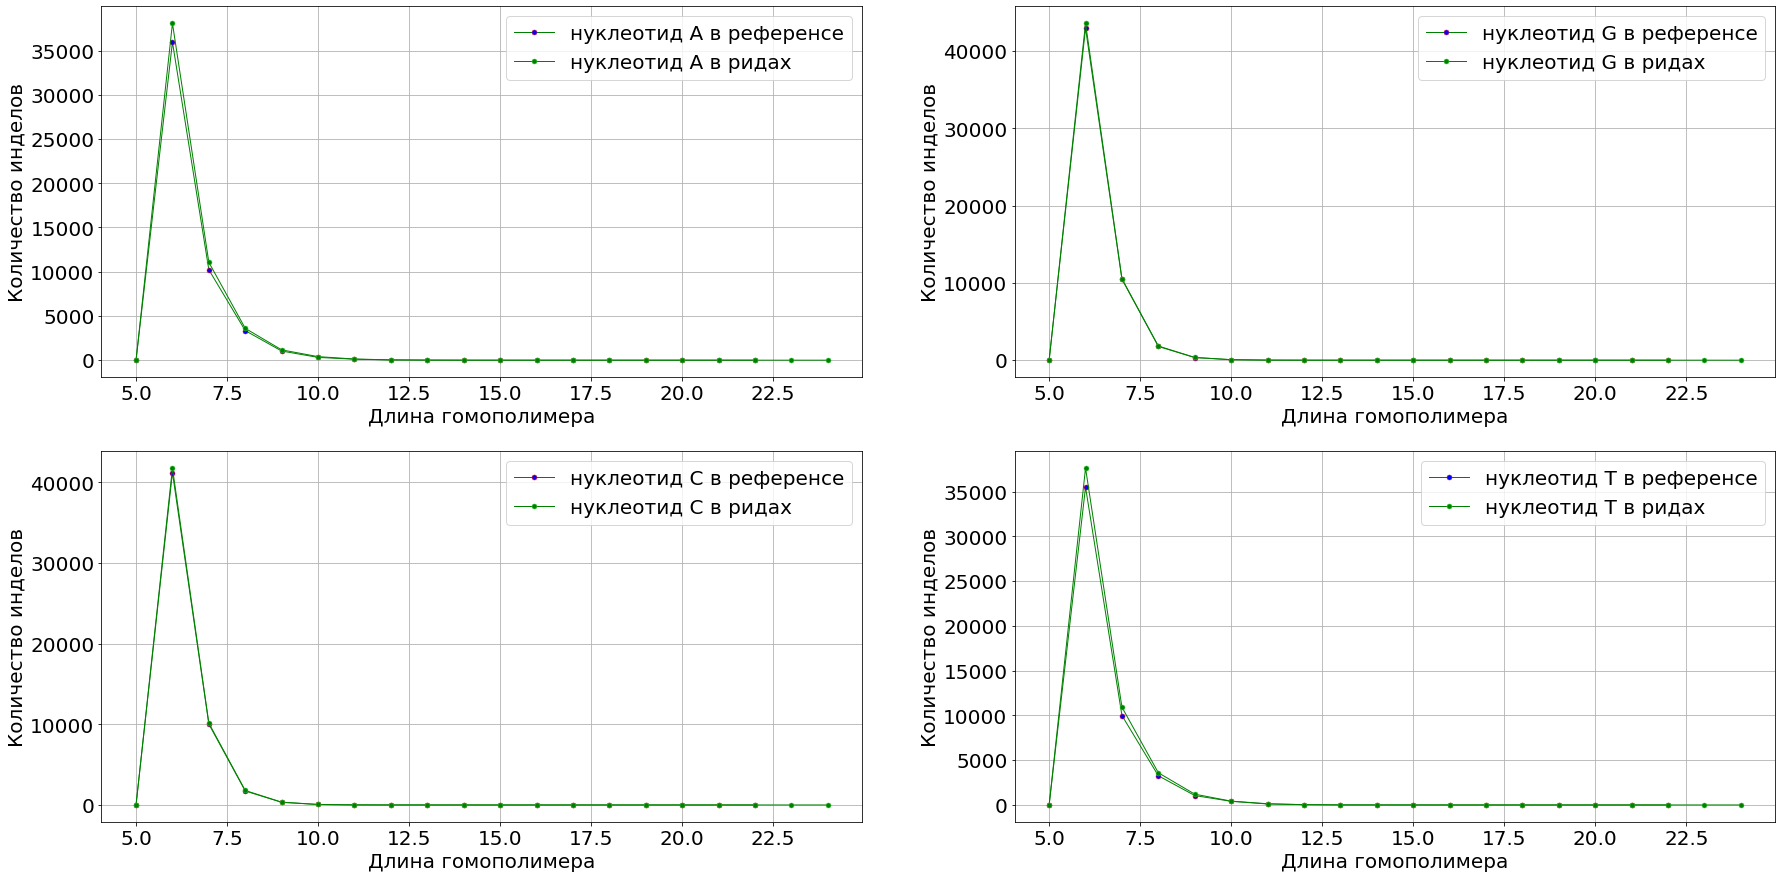

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(30, 15))

for nucl, ax in zip(['A', 'G', 'C', 'T'], [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]):
    xread, yread = [], []
    xref, yref = [], []
    for hom in homopolymers_ref:
        if hom[0] == nucl:
            xref.append(hom[1])
            yref.append(homopolymers_ref[hom])
    for hom in homopolymers_reads:
        if hom[0] == nucl:
            xread.append(hom[1])
            yread.append(homopolymers_reads[hom] / 33)
    plt.rcParams.update({'font.size': 20})
    ax.plot(xref, yref, label=f'нуклеотид {nucl} в референсе', 
             color='green', linewidth = 1, marker = 'o', 
             markersize = 5, markerfacecolor = 'blue',
             markeredgecolor = 'red', markeredgewidth = 0.5)
    ax.plot(xread[:20], yread[:20], label=f'нуклеотид {nucl} в ридах', 
             color='green', linewidth = 1, marker = 'o', 
             markersize = 5, markerfacecolor = 'green',
             markeredgecolor = 'limegreen', markeredgewidth = 0.5)
    
    ax.set_xlabel('Длина гомополимера')
    ax.set_ylabel('Количество инделов')
    ax.legend()
    ax.grid()

#### Статистика качества нуклеотидов


In [55]:
import seaborn as sns

def quality(sam):
    align = ps.AlignmentFile(sam, "r") 
    qual = []
    
    for read in align.fetch():
        count, cigar = 0, read.cigartuples
        if cigar == None:
            continue
        for i, c in cigar:
            if i == 0:
                count += c
            if i == 1:
                # поскольку нужно учесть смещение из-за ASCII-кодирования
                qual.append(ord(read.qual[count]) - 33)
    
    plt.figure(figsize=(12, 12))
    plt.xlabel('Качество нуклеотида')
    plt.ylabel('Частота')
    plt.grid()
    sns.kdeplot(qual)

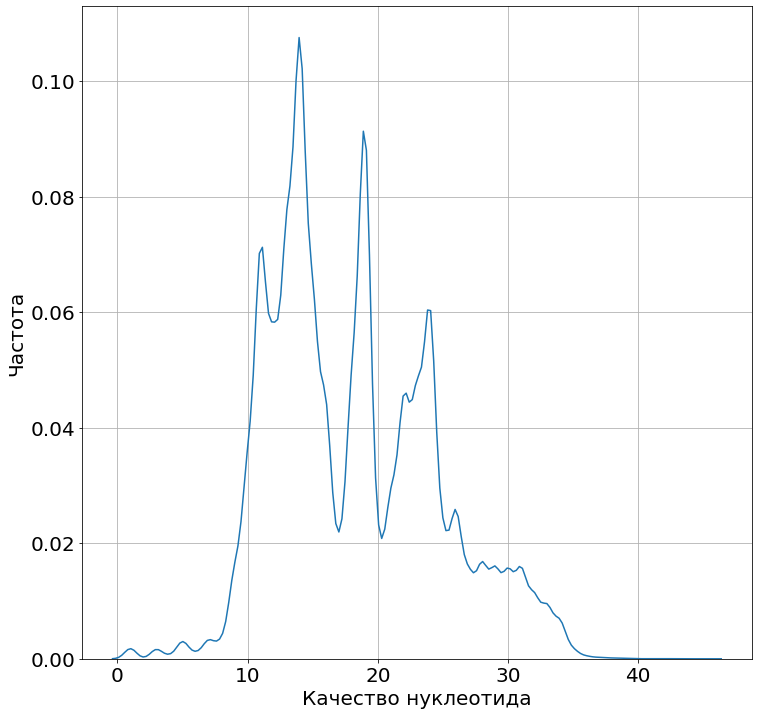

In [56]:
quality('alignment3.sam')

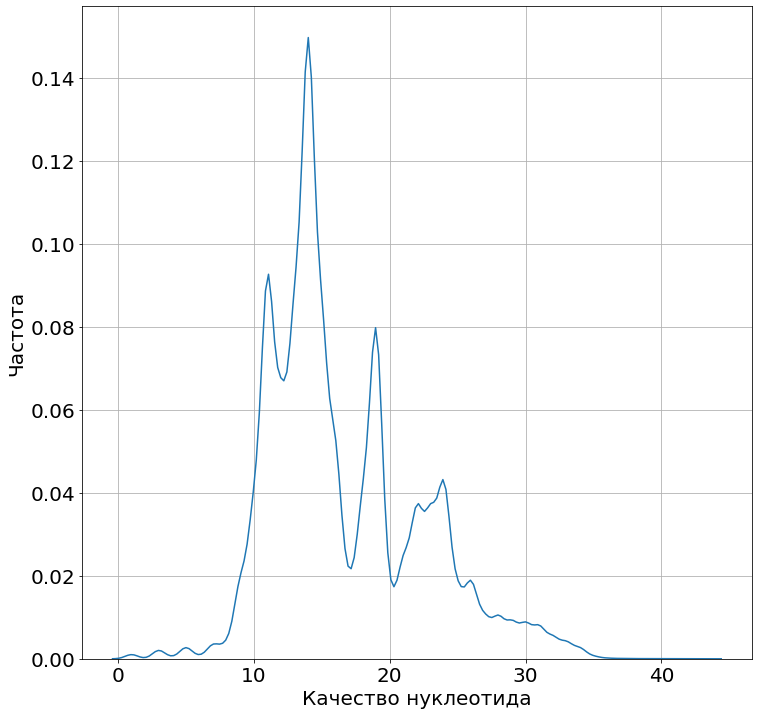

In [57]:
quality('alignment4.sam')